# GLMの尤度比検定と検定の非対称性
- パラメトリック(parametric)なモデル: 比較的に少数のパラメーターを持つモデル
- ノンパラメトリック: 多数のパラメーターを使って自由自在な構造を持つ

## 2種類の過誤
- 第1種の過誤：帰無仮説が正しいのに棄却された。
- 第2種の過誤：帰無仮説が誤っているのに採択された。

## パラメトリックブートストラップ法

In [1]:
import pandas as pd
import numpy as np
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

- 帰無仮説：一定モデル(パラメーター数$k = 1, \beta_2 = 0$)が真のモデル
- 対立仮説: xモデル($k = 2, \beta_2\neq 0$)

In [2]:
data = pd.read_csv('data/data3a.csv')[['y', 'x']]
print(data.describe())

                y           x
count  100.000000  100.000000
mean     7.830000   10.089100
std      2.624881    1.008049
min      2.000000    7.190000
25%      6.000000    9.427500
50%      8.000000   10.155000
75%     10.000000   10.685000
max     15.000000   12.400000


In [3]:
fits = []
formulas = ['y ~ 1', 'y ~ x']
for i in range(len(formulas)):
    fits.append(smf.glm(formula=formulas[i], data = data, family = sm.families.Poisson()).fit())
delta_D1x = fits[0].deviance - fits[1].deviance
print("一定モデルとxモデルの残差逸脱度の差 ΔD = " + str(delta_D1x))

一定モデルとxモデルの残差逸脱度の差 ΔD = 4.51394107885


In [4]:
data['y_rnd'] = np.random.poisson(data.y.mean(), 100)
print(data[['y_rnd']].describe())

           y_rnd
count  100.00000
mean     7.76000
std      2.79292
min      1.00000
25%      5.00000
50%      7.50000
75%     10.00000
max     14.00000


In [5]:
def bootstrape(data, n):
    def getDD():
        data['y_rnd'] = np.random.poisson(data.y.mean(), len(data.y))
        fits = []
        formulas = ['y_rnd ~ 1', 'y_rnd ~ x']
        for i in range(len(formulas)):
            fits.append(smf.glm(formula=formulas[i], data = data, family = sm.families.Poisson()).fit())
        return fits[0].deviance - fits[1].deviance
    return pd.Series(getDD() for i in range(n))

In [6]:
dd12 = bootstrape(data, 1000)

In [7]:
print(dd12.describe().round(2))

count    1000.00
mean        1.02
std         1.40
min         0.00
25%         0.11
50%         0.47
75%         1.36
max         9.70
dtype: float64


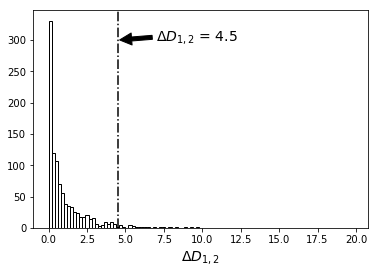

In [8]:
plt.hist(dd12, bins=np.arange(0, 20, 0.2), ec='black', color='white')
plt.xlabel(r'$\Delta D_{1,2}$', fontsize=14)
plt.annotate(r"$\Delta D_{1,2}$ = 4.5", xy=(4.5,300), xytext=(7, 300),
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=14)
plt.axvline(x=delta_D1x, linestyle='dashdot', color='black')
plt.show()

In [9]:
print("1000個中4.5より大きい数：" + str((dd12>=4.5).sum()))
print("逸脱度のP値が" + str((dd12 >= 4.5).sum()/1000) + "となるため、帰無仮説が棄却された")
print("P=0.05となる逸脱度の差：" + str(round(dd12.quantile(0.95), 2)))

1000個中4.5より大きい数：32
逸脱度のP値が0.032となるため、帰無仮説が棄却された
P=0.05となる逸脱度の差：3.95


## $\chi^2$分布を使った近似計算
- statsmodels.stats.anova.anova_lm()はGLMに対応していないので、Rで計算した。
- $\chi^2$分布はサンプルサイズが大きい場合に有効な近似計算である。

In [13]:
import pyper
r = pyper.R(use_numpy='True', use_pandas='True')
r.assign("data", data)
r("fit1 = glm(data$y ~ 1, family = poisson)")
r("fit2 = glm(data$y ~ data$x, family = poisson)")
print(r("anova(fit1, fit2, test = 'Chisq')"))
print("==================================")
print("逸脱度の差が4.5になるP値は0.0336となり、帰無仮説は棄却される。")

try({anova(fit1, fit2, test = 'Chisq')})
Analysis of Deviance Table

Model 1: data$y ~ 1
Model 2: data$y ~ data$x
  Resid. Df Resid. Dev Df Deviance Pr(>Chi)  
1        99     89.507                       
2        98     84.993  1   4.5139  0.03362 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

逸脱度の差が4.5になるP値は0.0336となり、帰無仮説は棄却される。
